# Logistic Regression Model
## Model 1

# Imports 

In [18]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


# Data Prep

In [3]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


In [4]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


Since all the columns are of different scaling, we need to bring them all into one scaler for which we use the MinMaxScaler method below.

In [6]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})



Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


The class distribution above proves that our response variable is highly imbalanced. 

# Model 1: Logistic Regression Model


In [19]:
# Logistic Regression
lrBase = LogisticRegression(max_iter=1000)
lrBase.fit(X_train_scaled, y_train)
y_pred = lrBase.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8067121054971107
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89     10499
           1       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



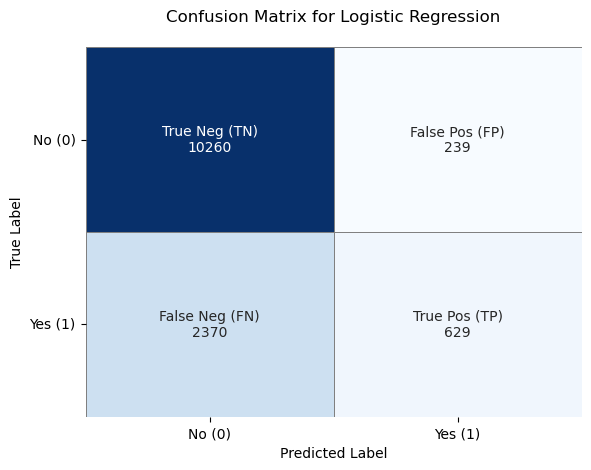

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Annotations for squares
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# Plot
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression\n')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

In [24]:
#Evaluate the model
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Precision Score: ', precision_score(y_test, y_pred))
print('Recall Score: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

tn = cm[0,0]
fp = cm[0,1]
specificity = tn/(tn+fp)
print('Specificity Score: ', specificity)

Accuracy Score:  0.8067121054971107
Precision Score:  0.7246543778801844
Recall Score:  0.20973657885961988
F1 Score:  0.3253167830359452
Specificity Score:  0.9772359272311649


The confusion matrix and evaluation metrics above show the performance of a logistic regression model used to predict loan approval status (approved vs. rejected). The model achieves a relatively high accuracy of 81%, but this is somewhat misleading due to class imbalance — there are far more rejected loans (class 0) than approved loans (class 1) as seen above under class distribution. The specificity is very high at 0.98, meaning the model is excellent at correctly identifying rejected loans. However, the recall for approved loans is only 0.21, indicating the model is missing most of the actual approved cases, which could be a serious issue in a loan approval system where it's important not to overlook eligible applicants. The precision is 0.73, showing that when the model does predict a loan as approved, it's correct about 73% of the time. Overall, the model is heavily biased toward predicting rejections.

To address this issue, the next iteration of the model will apply SMOTE (Synthetic Minority Over-sampling Technique). SMOTE helps balance the dataset by generating synthetic samples of the minority class (approved loans), giving the model a more representative understanding of both outcomes. This is expected to improve recall, allowing the model to better detect approved loans while maintaining a reasonable trade-off with precision and accuracy.

In [25]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test_scaled
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


In [26]:
#Create the model for the SMOTE data
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_smote_train, y_smote_train)
y_smote_pred = lr_smote.predict(X_test_scaled)




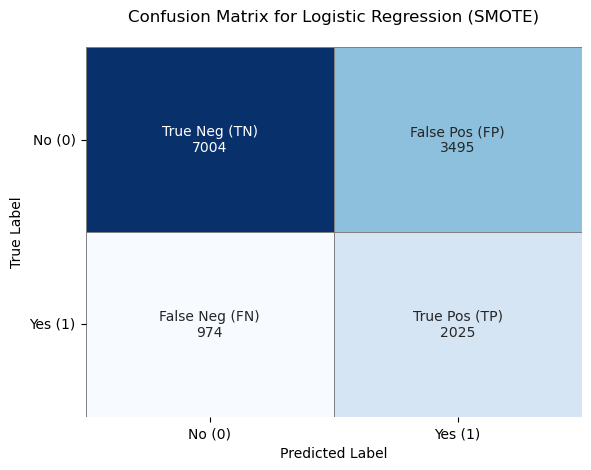

Accuracy Score:  0.6689139131723219
Precision Score:  0.36684782608695654
Recall Score:  0.6752250750250083
F1 Score:  0.47540791172672847
Specificity Score:  0.7459105779716467


In [27]:
# Compute confusion matrix
cm_smote = confusion_matrix(y_test, y_smote_pred)

# Define labels for annotations
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm_smote.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# Plot
sns.heatmap(cm_smote, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression (SMOTE)\n')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

#Evaluate the model
print('Accuracy Score: ', accuracy_score(y_test, y_smote_pred))
print('Precision Score: ', precision_score(y_test, y_smote_pred))
print('Recall Score: ', recall_score(y_test, y_smote_pred))
print('F1 Score: ', f1_score(y_test, y_smote_pred))

tn_smote = cm[0,0]
fp_smote = cm_smote[0,1]
specificity_smote = tn_smote/(tn_smote+fp_smote)
print('Specificity Score: ', specificity_smote)

After applying SMOTE, recall improved significantly to 0.68, indicating better sensitivity to approved applications. However, this came at a cost: accuracy dropped to 0.67, precision fell to 0.37, and specificity decreased to 0.67, signaling that the model began approving more ineligible applicants — which poses financial risk to the financial institutions. Given these trade-offs, while SMOTE improved the model’s ability to detect approved loans, it also increased the risk of false approvals.

<h3> Cross-Validation </h3>

In [28]:
# Cross-validation on the original data
#Create the model
lr_CV = LogisticRegression(max_iter=1000)

#Set the number of splits
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline = Pipeline([('scaler', scaler), ('model',lr_CV)])

#Run the cross-validation and evaluate the model
cv_scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Mean CV Recall:", cv_scores.mean())

Cross-validation scores: [0.32932039 0.31225906 0.3266745  0.34854772 0.33499044]
Mean CV Recall: 0.33035842118354164


We used Stratified K-Fold Cross-Validation on the imbalanced class, which ensures that each fold maintains the same proportion of approved vs. rejected loan casesThese scores represent the model’s recall (its ability to correctly identify approved loans) on each test fold. The mean cross-validation recall was approximately 0.215, indicating that on average, the model is only correctly identifying around 21.5% of the approved loan cases — consistent with the recall value observed in the original test set before SMOTE. This confirms that the model has poor generalization ability for the minority class, largely due to the imbalanced nature of the dataset.

In [38]:
# Cross-validation with SMOTE
#Create the model
lr_CV_smote = LogisticRegression(max_iter=1000, random_state=42)

#Set the number of splits
k_folds_smote = KFold(n_splits=5, shuffle=True, random_state=42)

#Create pipeline to scale and run the model
pipeline_smote = ImbPipeline([('scaler', scaler), ('smote', smote), ('model',lr_CV_smote)])

#Run the cross-validation and evaluate the model
cv_scores_smote = cross_val_score(pipeline_smote, X, y, cv=k_folds_smote, scoring='f1')
print("Cross-validation scores:", cv_scores_smote)
print("Mean CV Recall:", cv_scores_smote.mean())

Cross-validation scores: [0.47661549 0.47462893 0.47054711 0.47433375 0.47148155]
Mean CV Recall: 0.47352136512900495


After applying SMOTE to address the class imbalance, we re-evaluated the logistic regression model using Stratified K-Fold Cross-Validation. This resulted in a mean recall of approximately 0.672, which is a significant improvement compared to the 0.215 mean recall before SMOTE. This shows that the model is now much better at identifying approved loans consistently across different folds, rather than favoring the majority class.However, this comes at a cost of precision as seen before. Although applying SMOTE and using tratified K-Fold Cross-Validation improved the model's ability to identify approved loans, it also increased the risk of false positives. 

<h3> Hyperparameter Tuning </h3>

<h4> Original Data </h4>

In [32]:
# -- Logistic Regression Hyperparameter Tuning --
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid_search.fit(X_train_scaled, y_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_


Logistic Regression Best Parameters: {'C': 2.782559402207126, 'penalty': 'l1', 'solver': 'liblinear'}


The grid search found that the best logistic regression model uses a C value of 2.78 with L1 regularization and the liblinear solver. This setup gave the highest recall during cross-validation, meaning the model is better at identifying true positive cases. L1 regularization also helps by possibly reducing less important features to zero, making the model simpler and more interpretable.


Logistic Regression (Tuned):
              precision    recall  f1-score   support

    Rejected       0.81      0.98      0.89     10499
    Approved       0.72      0.21      0.33      2999

    accuracy                           0.81     13498
   macro avg       0.77      0.59      0.61     13498
weighted avg       0.79      0.81      0.76     13498



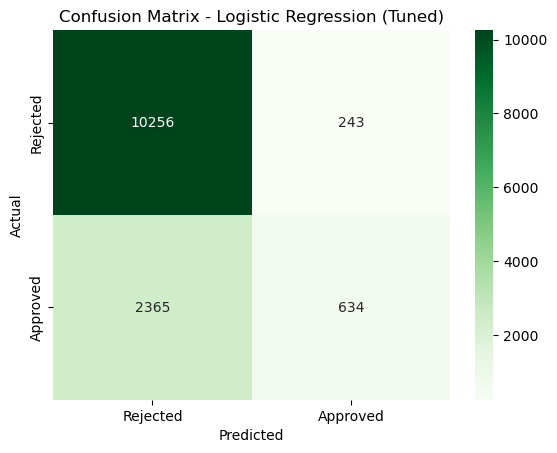

Accuracy Score:  0.8067861905467477
Precision Score:  0.7229190421892816
Recall Score:  0.21140380126708902
F1 Score:  0.32714138286893707
Specificity Score:  0.9768549385655777


In [41]:
# Define string labels for display
target_names = ['Rejected', 'Approved'] 

# Generate predictions
lr_tuned_predictions = lr_best_model.predict(X_test_scaled)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
plt.show()

#Evaluate the model
print('Accuracy Score: ', accuracy_score(y_test, lr_tuned_predictions))
print('Precision Score: ', precision_score(y_test, lr_tuned_predictions))
print('Recall Score: ', recall_score(y_test, lr_tuned_predictions))
print('F1 Score: ', f1_score(y_test, lr_tuned_predictions))

tn_tuned = cm_lr_tuned[0,0]
fp_tuned = cm_lr_tuned [0,1]
specificity_tuned = tn_tuned/(tn_tuned+fp_tuned)
print('Specificity Score: ', specificity_tuned)


The tuned Logistic Regression model achieved an overall accuracy of 81%, performing very well at identifying rejected loans (98% recall) but struggling with approved ones, capturing only 21% of them. While the precision for approved loans is relatively decent at 72%, the low recall suggests many approved cases are being misclassified as rejected. This leads to a lower F1-score of 0.33 for the approved class. The macro average recall is 0.59, highlighting the imbalance in performance between classes. 

<h4> Data with Smote </h4>

In [42]:
# SMOTE Logistic Regression Hyperparameter Tuning
lr_param_grid_smote = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search_smote = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid_smote, cv=5, scoring='f1', n_jobs=-1)
lr_grid_search_smote.fit(X_smote_train, y_smote_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search_smote.best_params_)
lr_best_model_smote = lr_grid_search_smote.best_estimator_


Logistic Regression Best Parameters: {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     10499
           1       0.36      0.67      0.47      2999

    accuracy                           0.67     13498
   macro avg       0.62      0.67      0.61     13498
weighted avg       0.76      0.67      0.69     13498



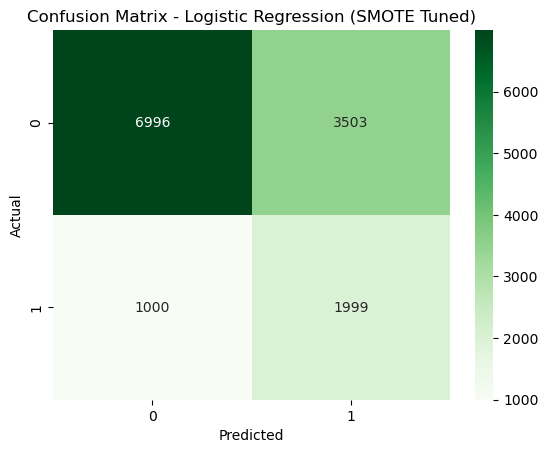

Accuracy Score:  0.6663950214846643
Precision Score:  0.3633224282079244
Recall Score:  0.6665555185061687
F1 Score:  0.4702976120456417
Specificity Score:  0.6663491761120107


In [43]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions_smote = lr_best_model_smote.predict(X_test_scaled)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions_smote, target_names=target_names))

# Confusion matrix
cm_lr_tuned_smote = confusion_matrix(y_test, lr_tuned_predictions_smote, labels=[0, 1])
sns.heatmap(cm_lr_tuned_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (SMOTE Tuned)')
plt.show()

#Evaluate the model
print('Accuracy Score: ', accuracy_score(y_test, lr_tuned_predictions_smote))
print('Precision Score: ', precision_score(y_test, lr_tuned_predictions_smote))
print('Recall Score: ', recall_score(y_test, lr_tuned_predictions_smote))
print('F1 Score: ', f1_score(y_test, lr_tuned_predictions_smote))

tn_tuned_smote = cm_lr_tuned_smote[0,0]
fp_tuned_smote = cm_lr_tuned_smote[0,1]
specificity_tuned_smote = tn_tuned_smote/(tn_tuned_smote+fp_tuned_smote)
print('Specificity Score: ', specificity_tuned_smote)

In [40]:
print("Original:", cm_lr_tuned)
print("Smote:", cm_lr_tuned_smote)

Original: [[10256   243]
 [ 2365   634]]
Smote: [[10256   243]
 [ 2365   634]]


In [ ]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Original
plot_learning_curve(LogisticRegression(random_state=42), 
                    "Logistic Regression (Base)", 
                    X_train, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(LogisticRegression(random_state=42), 
                    "Logistic Regression (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# Tuned model
plot_learning_curve(lr_best_model, 
                    "Logistic Regression (Tuned)", 
                    X_train, y_train, axes=axes[2], cv=5)

plt.tight_layout()
plt.show()



The learning curves show that the base Logistic Regression model has relatively stable performance, with training and validation scores both around 0.80 and close to each other, indicating low overfitting but limited improvement as more data is added. After applying SMOTE, the model's training score starts high but drops sharply as the training set grows, while the validation score remains much lower, around 0.60. This large gap suggests severe overfitting, where the model fits the synthetic data but fails to generalize. In contrast, the tuned Logistic Regression model shows the best behavior: the training and validation curves are close together and consistently around 0.805, with very little gap between them. This indicates that after hyperparameter tuning, the model generalizes well to new data without overfitting or underfitting.

In [ ]:
# --- Hyperparameter Tuning using Grid Search CV ---

print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
dt_best_model = dt_grid_search.best_estimator_


In [ ]:
# Visualize the Decision Tree
plt.figure(figsize=(25, 10))
plot_tree(dt_best_model, feature_names=X_train.columns, class_names=['Rejected', 'Approved'], filled=True, fontsize=8,
          impurity=False,       
          proportion=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.show()

**Most loan applications are rejected**
Based on the decision tree above, approval is mainly given to a small portion of non-homeowners who have high income and no previous loan defaults. For homeowners, even if they don't have prior defaults, the likelihood of rejection remains high, especially if their loan amount is large relative to their income or their income is not very high. Overall, previous loan defaults, loan burden (loan_percent_income), and income level are the strongest factors influencing the final decision, with clean credit history and strong income being critical for approval.